In [2]:
import numpy as np
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import torch
import lightning as L
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
%load_ext tensorboard

In [4]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
from typing import List, Tuple, Dict
import numpy as np

bits_per_sample = 16
samples_per_symbol = 100

def generate_qpsk_contrastive_dataset(
    num_clean_samples: int,
    bits_per_sample: int = bits_per_sample,
    noise_types: List[str] = [
        "gaussian", "impulse", "uniform", "laplacian",
        "rayleigh", "exponential", "phase_noise",
        "frequency_drift", "multipath", "quantization",
        "gaussian+impulse", "phase_noise+frequency_drift"
    ],
    snr_db: float = 10.0,
    samples_per_symbol: int = samples_per_symbol,
    carrier_freq: int = 50,
) -> Tuple[np.ndarray, np.ndarray, Dict, np.ndarray]:
    """
    Генерирует QPSK-сигналы с разнообразными шумами и их комбинациями.

    Возвращает:
    - all_noised_iq: Зашумлённые сигналы [total_samples, 2, samples_per_signal].
    - labels: Метки (ID исходного чистого сигнала) [total_samples].
    - metadata: Параметры генерации (не использовать в датасете).
    - clean_signals: Неаугментированные (чистые) сигналы [num_clean_samples, 2, samples_per_signal].
    """
    symbols_per_sample = bits_per_sample // 2
    samples_per_signal = symbols_per_sample * samples_per_symbol
    t = np.arange(samples_per_signal) / (samples_per_symbol * carrier_freq)

    # Чистые QPSK-сигналы (без шума)
    clean_signals = np.zeros((num_clean_samples, 2, samples_per_signal))
    for sample_idx in range(num_clean_samples):
        binary_data = np.random.randint(0, 2, (symbols_per_sample, 2))
        I, Q = np.zeros(samples_per_signal), np.zeros(samples_per_signal)

        for sym_idx, (b1, b2) in enumerate(binary_data):
            start = sym_idx * samples_per_symbol
            end = start + samples_per_symbol
            I[start:end] = 1.0 if b1 == 0 else -1.0
            Q[start:end] = 1.0 if b2 == 0 else -1.0

        clean_signals[sample_idx, 0] = I * np.cos(2 * np.pi * carrier_freq * t)
        clean_signals[sample_idx, 1] = Q * np.sin(2 * np.pi * carrier_freq * t)

    # Добавляем шумы к каждому чистому сигналу
    total_samples = num_clean_samples * len(noise_types)
    all_noised_iq = np.zeros((total_samples, 2, samples_per_signal))
    labels = np.zeros(total_samples, dtype=int)

    for sample_idx in range(num_clean_samples):
        for noise_idx, noise_type in enumerate(noise_types):
            global_idx = sample_idx * len(noise_types) + noise_idx
            I, Q = clean_signals[sample_idx].copy()

            signal_power = np.mean(I**2 + Q**2)
            noise_power = signal_power / (10 ** (snr_db / 10))

            if noise_type == "gaussian":
                I += np.random.normal(0, np.sqrt(noise_power / 2), samples_per_signal)
                Q += np.random.normal(0, np.sqrt(noise_power / 2), samples_per_signal)

            elif noise_type == "impulse":
                impulse_mask = np.random.choice([0, 1], size=samples_per_signal, p=[0.95, 0.05])
                I += impulse_mask * np.random.normal(0, np.sqrt(noise_power * 5), samples_per_signal)
                Q += impulse_mask * np.random.normal(0, np.sqrt(noise_power * 5), samples_per_signal)

            elif noise_type == "uniform":
                I += np.random.uniform(-np.sqrt(3 * noise_power / 2), np.sqrt(3 * noise_power / 2), samples_per_signal)
                Q += np.random.uniform(-np.sqrt(3 * noise_power / 2), np.sqrt(3 * noise_power / 2), samples_per_signal)

            elif noise_type == "laplacian":
                I += np.random.laplace(0, np.sqrt(noise_power / 2), samples_per_signal)
                Q += np.random.laplace(0, np.sqrt(noise_power / 2), samples_per_signal)

            elif noise_type == "rayleigh":
                I *= np.random.rayleigh(1, samples_per_signal)
                Q *= np.random.rayleigh(1, samples_per_signal)

            elif noise_type == "exponential":
                I *= np.random.exponential(1, samples_per_signal)
                Q *= np.random.exponential(1, samples_per_signal)

            elif noise_type == "phase_noise":
                phase_noise = np.random.normal(0, 0.1, samples_per_signal).cumsum()
                I_new = I * np.cos(phase_noise) - Q * np.sin(phase_noise)
                Q_new = I * np.sin(phase_noise) + Q * np.cos(phase_noise)
                I, Q = I_new, Q_new

            elif noise_type == "frequency_drift":
                freq_drift = 0.1 * np.sin(2 * np.pi * 0.01 * t)
                I = I * np.cos(2 * np.pi * (carrier_freq + freq_drift) * t)
                Q = Q * np.sin(2 * np.pi * (carrier_freq + freq_drift) * t)

            elif noise_type == "multipath":
                delay = samples_per_symbol // 2
                attenuation = 0.5
                I[delay:] += attenuation * I[:-delay]
                Q[delay:] += attenuation * Q[:-delay]

            elif noise_type == "quantization":
                bits = 4
                levels = 2 ** bits
                I = np.round(I * levels) / levels
                Q = np.round(Q * levels) / levels

            elif noise_type == "gaussian+impulse":
                I += np.random.normal(0, np.sqrt(noise_power / 2), samples_per_signal)
                Q += np.random.normal(0, np.sqrt(noise_power / 2), samples_per_signal)
                impulse_mask = np.random.choice([0, 1], size=samples_per_signal, p=[0.98, 0.02])
                I += impulse_mask * np.random.normal(0, np.sqrt(noise_power * 20), samples_per_signal)
                Q += impulse_mask * np.random.normal(0, np.sqrt(noise_power * 20), samples_per_signal)

            elif noise_type == "phase_noise+frequency_drift":
                phase_noise = np.random.normal(0, 0.1, samples_per_signal).cumsum()
                I_new = I * np.cos(phase_noise) - Q * np.sin(phase_noise)
                Q_new = I * np.sin(phase_noise) + Q * np.cos(phase_noise)
                I, Q = I_new, Q_new
                freq_drift = 0.1 * np.sin(2 * np.pi * 0.01 * t)
                I = I * np.cos(2 * np.pi * (carrier_freq + freq_drift) * t)
                Q = Q * np.sin(2 * np.pi * (carrier_freq + freq_drift) * t)

            all_noised_iq[global_idx, 0] = I
            all_noised_iq[global_idx, 1] = Q
            labels[global_idx] = sample_idx

    metadata = {
        "noise_types": noise_types,
        "snr_db": snr_db,
        "samples_per_symbol": samples_per_symbol,
        "carrier_freq": carrier_freq,
    }

    return all_noised_iq, labels, metadata, clean_signals


In [6]:
num_clean_samples = 5
noise_types = ["gaussian", "impulse", "uniform", "laplacian",
        "rayleigh", "exponential"]
snr_db = 0.2

In [7]:
noised_iq, labels, _, clean_sign = generate_qpsk_contrastive_dataset(
            num_clean_samples, 
            bits_per_sample=bits_per_sample,
            noise_types=noise_types,
            snr_db=snr_db,)

In [8]:
signal_len = bits_per_sample //2 * samples_per_symbol
signal_len

800

In [9]:
clean_sign.shape

(5, 2, 800)

In [10]:
labels[:50]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4])

In [11]:
noised_iq.shape

(30, 2, 800)

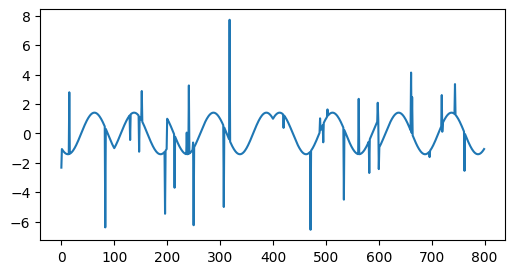

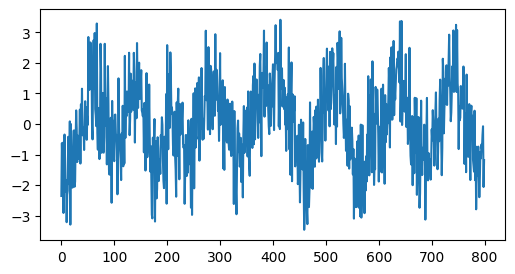

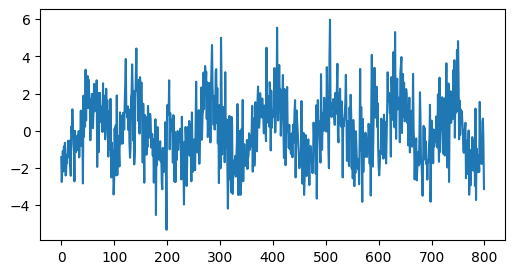

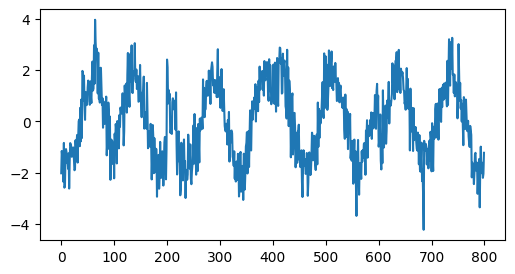

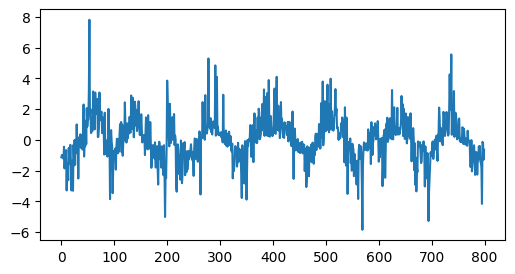

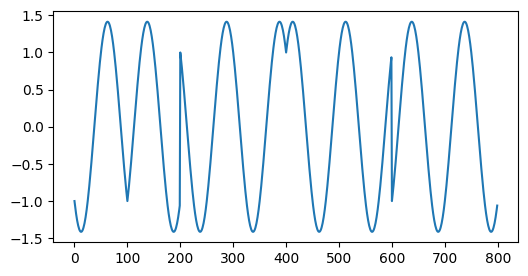

In [12]:
for i in range(1,len(noise_types)):
    noised_data = noised_iq[i,0] - noised_iq[i,1] # I-Q (опять таки разбиение по каналам)
    plt.figure(figsize=(6,3))
    plt.plot(noised_data)

plt.figure(figsize=(6,3))
plt.plot(clean_sign[0,0,:] - clean_sign[0,1,:])
#Эффективнее будет моделировать не разные типы шумов с стационарными параметрами, а один тип шумов с переменными параметрами

In [13]:
class QPSKDataset(Dataset):
    def __init__(self, num_clean_samples=10000, noise_types=noise_types, snr_db=snr_db):
        self.noised_iq, self.labels, _, self.clean_data = generate_qpsk_contrastive_dataset(
            num_clean_samples, 
            bits_per_sample=bits_per_sample,
            noise_types=noise_types,
            snr_db=snr_db,
            samples_per_symbol= samples_per_symbol
        )
        self.num_noise_types = len(noise_types)

    def __len__(self):
        return len(self.noised_iq)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.noised_iq[idx]),  # [2, samples_per_signal]
            self.labels[idx],                   # Метка (ID чистого сигнала)
            torch.FloatTensor(self.clean_data[idx // self.num_noise_types]) #Чистый сигнал, соответствующий уникальному label
        )


In [14]:
dataset = QPSKDataset(num_clean_samples=10000)

In [15]:
dl = DataLoader(dataset, batch_size=len(noise_types)* 20, shuffle=False)

In [16]:
for i in range(1, 5):
    print(dataset[i])

(tensor([[ 1.0000,  0.9980,  0.9921,  ..., -0.9823,  2.4554, -0.9980],
        [ 0.0000,  0.0628,  0.1253,  ...,  0.1874,  1.1353,  0.0628]]), 0, tensor([[ 1.0000,  0.9980,  0.9921,  ..., -0.9823, -0.9921, -0.9980],
        [ 0.0000,  0.0628,  0.1253,  ...,  0.1874,  0.1253,  0.0628]]))
(tensor([[ 1.0671, -0.0434, -0.1190,  ..., -1.5230, -1.3965, -0.6882],
        [-0.7619, -0.9908,  0.5220,  ...,  0.6932,  0.6364, -0.5107]]), 0, tensor([[ 1.0000,  0.9980,  0.9921,  ..., -0.9823, -0.9921, -0.9980],
        [ 0.0000,  0.0628,  0.1253,  ...,  0.1874,  0.1253,  0.0628]]))
(tensor([[ 0.7449,  0.3582,  1.5137,  ...,  0.9265,  0.3460,  0.4255],
        [ 1.3254,  1.6120,  0.5728,  ...,  0.7899,  0.8693, -0.3259]]), 0, tensor([[ 1.0000,  0.9980,  0.9921,  ..., -0.9823, -0.9921, -0.9980],
        [ 0.0000,  0.0628,  0.1253,  ...,  0.1874,  0.1253,  0.0628]]))
(tensor([[ 0.4437,  1.2025,  1.1591,  ..., -1.1838, -0.6011, -0.6204],
        [ 0.0000,  0.0503,  0.0576,  ...,  0.6583,  0.1069,  0.12

In [17]:
class CNNEncoder(nn.Module):
    def __init__(self, input_channels=2, embed_dim=128):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Layer 1: [batch, 2, L] -> [batch, 32, L//2]
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            # Layer 2: [batch, 32, L//2] -> [batch, 64, L//4]
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            # Layer 3: [batch, 64, L//4] -> [batch, 128, L//8]
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            # Layer 4: [batch, 128, L//8] -> [batch, 256, L//16]
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        
        # Adaptive pooling для произвольной длины сигнала
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.projection = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.ReLU(),
            nn.LayerNorm(embed_dim)
        )

    def forward(self, x):
        # x: [batch, 2, L]
        features = self.conv_layers(x)  # [batch, 256, L//16]
        pooled = self.global_pool(features).squeeze(-1)  # [batch, 256]
        embeddings = self.projection(pooled)  # [batch, embed_dim]
        return embeddings


In [18]:
class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=128, output_channels=2):
        super().__init__()
        
        # Начальное расширение эмбеддинга
        self.upsample = nn.Sequential(
            nn.Linear(embed_dim, 256 * 50),  # 50 - примерный размер после энкодера для L=1000
            nn.ReLU()
        )
        
        # Точные обратные операции к энкодеру
        self.deconv_layers = nn.Sequential(
            # Соответствует последнему слою энкодера: 256 -> 128
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            # Соответствует третьему слою энкодера: 128 -> 64
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            # Соответствует второму слою энкодера: 64 -> 32
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            # Соответствует первому слою энкодера: 32 -> output_channels
            nn.ConvTranspose1d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
        # Для точного восстановления длины
        self.final_adjust = nn.Sequential(
            nn.Upsample(scale_factor=1.0, mode='linear', align_corners=True),  # Масштабирование при необходимости
            nn.Conv1d(output_channels, output_channels, kernel_size=3, padding=1)
        )

    def forward(self, z, target_length=None):
        # z: [batch, embed_dim]
        x = self.upsample(z)
        
        # Рассчитываем expected_length после энкодера
        # Для L=1000: 1000 -> 500 -> 250 -> 125 -> 62 (поэтому 50 в upsample)
        x = x.view(-1, 256, 50)  # Примерный размер после энкодера
        
        x = self.deconv_layers(x)  # [batch, 2, ~L]
        
        #Интерполяция
        if target_length is not None:
            x = F.interpolate(x, size=target_length, mode='linear', align_corners=True)
            x = self.final_adjust(x)
        
        return x

In [19]:
class NTXentLabeledLoss(torch.nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings, labels):
        """
        embeddings: Тензор [batch_size, embedding_dim] (эмбеддинги сигналов).
        labels: Тензор [batch_size] с метками (одинаковые метки = позитивные пары).
        """
        batch_size = embeddings.size(0)
        
        # Нормализуем эмбеддинги
        embeddings = F.normalize(embeddings, p=2, dim=1)  # [batch, embed_dim]
        
        # Матрица косинусной схожести
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature  # [batch, batch]
        
        # Маска для позитивных пар (примеры с одинаковой меткой)
        pos_mask = (labels.unsqueeze(0) == (labels.unsqueeze(1)))  # [batch, batch]
        pos_mask.fill_diagonal_(False)  # Исключаем диагональ (i == j)
        
        # Лосс для каждого примера
        exp_sim = torch.exp(sim_matrix)
        exp_sim = exp_sim * (~torch.eye(batch_size).bool().to(embeddings.device))  # Исключаем self-similarity
        
        pos_pairs = torch.sum(exp_sim * pos_mask, dim=1)  # Сумма по позитивным парам
        neg_pairs = torch.sum(exp_sim, dim=1)             # Сумма по всем парам
        
        loss = -torch.log(pos_pairs / neg_pairs).mean()
        return loss

In [20]:
class PhaseLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        # [batch, 2, T]
        I_out, Q_out = output[:, 0, :], output[:, 1, :]
        I_tgt, Q_tgt = target[:, 0, :], target[:, 1, :]

        phase_out = torch.atan2(Q_out, I_out)
        phase_tgt = torch.atan2(Q_tgt, I_tgt)

        phase_diff = torch.angle(torch.exp(1j * (phase_out - phase_tgt)))
        return torch.mean(torch.abs(phase_diff))


In [21]:
encoder = CNNEncoder()
decoder= CNNDecoder()
enc_criterion = NTXentLabeledLoss()
dec_criterion = PhaseLoss()

In [22]:
class Denoiser(pl.LightningModule):
    def __init__(self, encoder=encoder, decoder=decoder, lr=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.lr = lr

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z, out
    

    def training_step(self, batch):
        
        augmented_data, label, clean_data = batch

        augmented_embedding = self.encoder(augmented_data)

        loss_enc = enc_criterion(augmented_embedding, label)

        decoded_data = self.decoder(augmented_embedding)

        loss_dec = dec_criterion(decoded_data, clean_data)

        total_loss = loss_enc + loss_dec

        self.log("train/enc_loss", loss_enc, prog_bar=True)
        self.log("train/dec_loss", loss_dec, prog_bar=True)
        self.log("train/loss", total_loss, prog_bar=True)


        return total_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "train/loss"}}
    



In [23]:
early_stop = EarlyStopping(monitor='train/loss', patience=10, verbose=True, mode='min')
checkpoint = ModelCheckpoint(monitor='train/loss', save_top_k=1, mode='min')

trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[early_stop, checkpoint],
    accelerator='auto',
    log_every_n_steps=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
model = Denoiser()

In [25]:
trainer.fit(model, dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | CNNEncoder | 168 K  | train
1 | decoder | CNNDecoder | 1.8 M  | train
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.813     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [27]:
#Загрузить веса последнего чекпоинта
model = Denoiser.load_from_checkpoint('lightning_logs/version_11/checkpoints/epoch=117-step=59000.ckpt')


In [28]:
num_inference_samples = 10  
noised_iq, labels, _, clean_sign = generate_qpsk_contrastive_dataset(
    num_inference_samples, 
    bits_per_sample=bits_per_sample,
    noise_types=noise_types,
    snr_db=snr_db,
)


In [32]:
noised_iq_tensor = torch.FloatTensor(noised_iq).to(device)

In [33]:
encoder.eval()
decoder.eval()

CNNDecoder(
  (upsample): Sequential(
    (0): Linear(in_features=128, out_features=12800, bias=True)
    (1): ReLU()
  )
  (deconv_layers): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose1d(32, 2, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (10): Tanh()
  )
  (final_adjust): Sequential(
    (0): Upsample(scale_factor=1.0, mode='linear')
    (1): Conv1d(2, 2, kernel_si

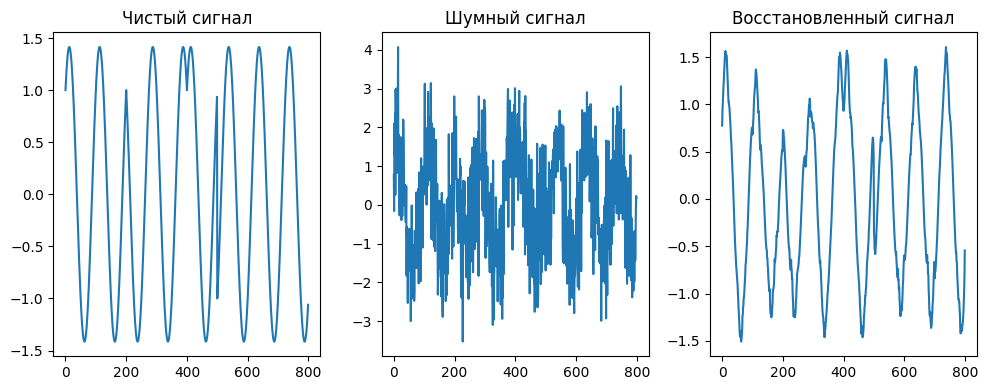

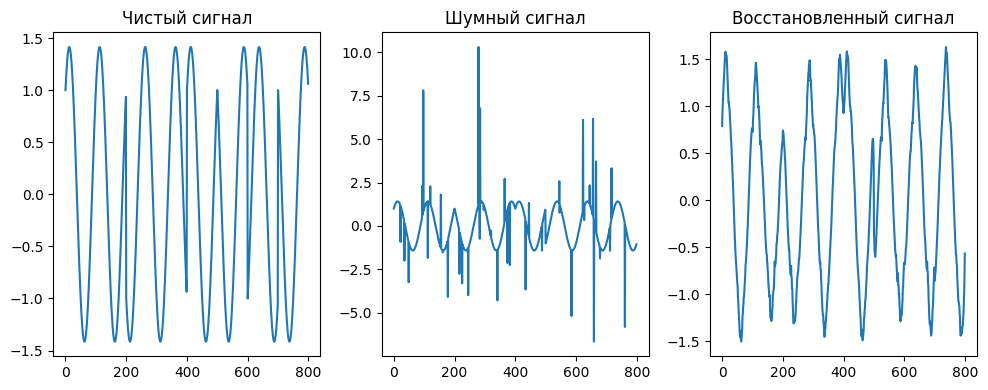

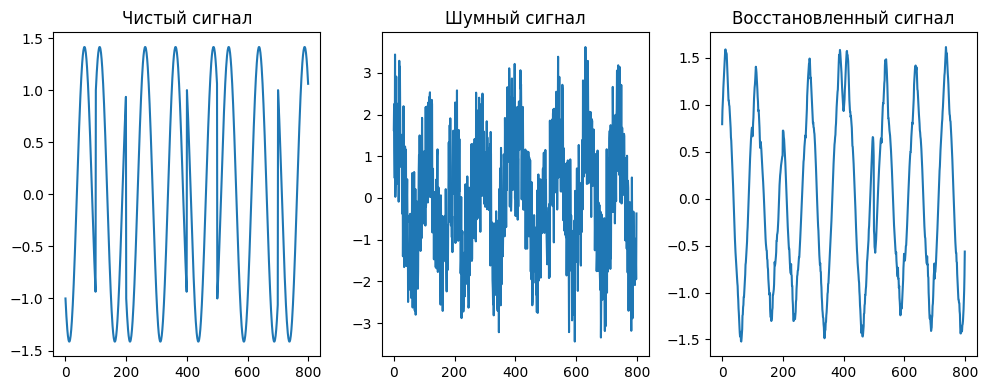

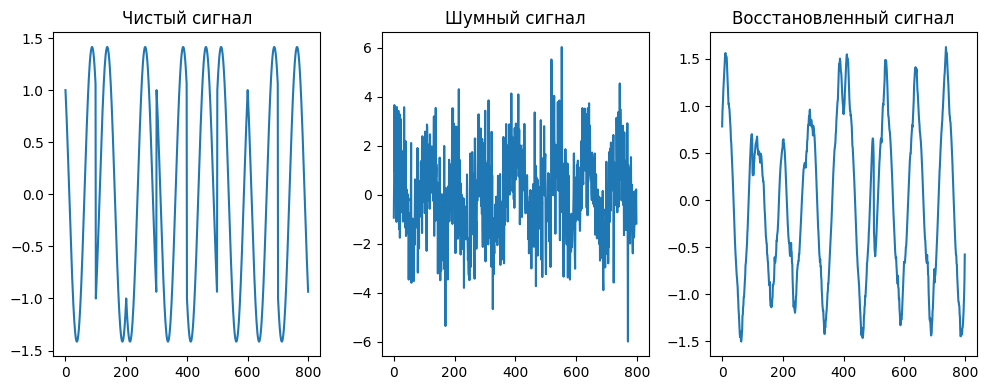

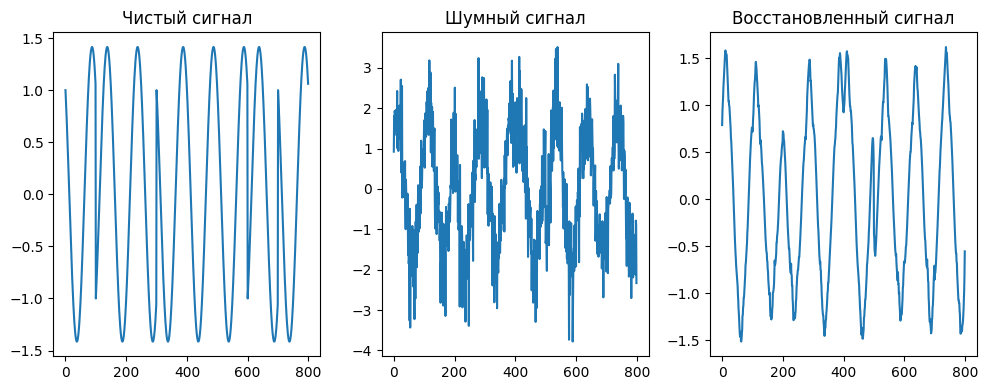

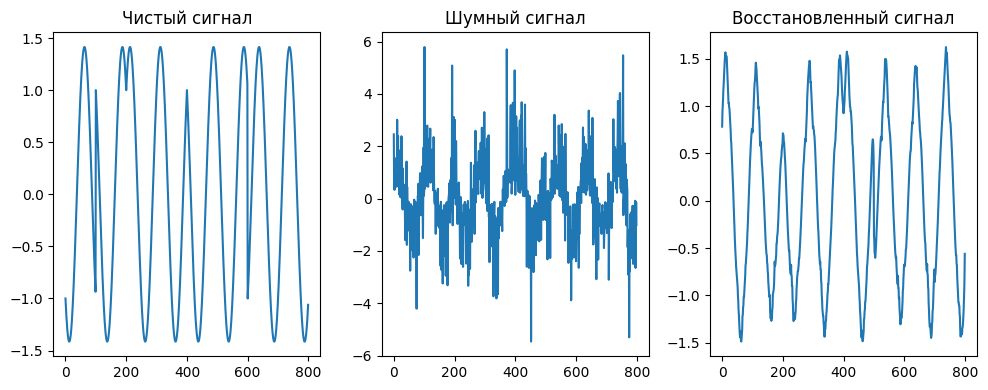

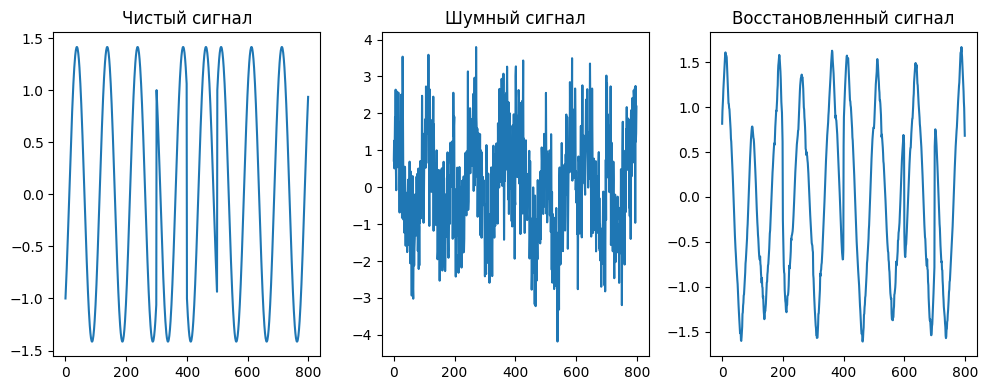

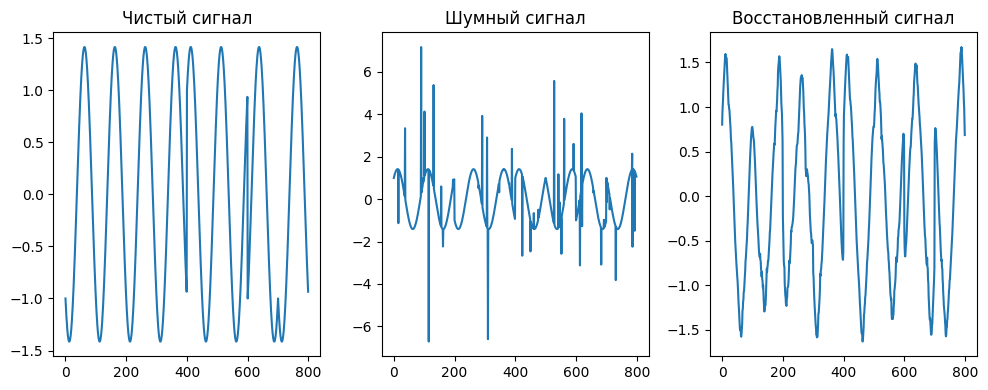

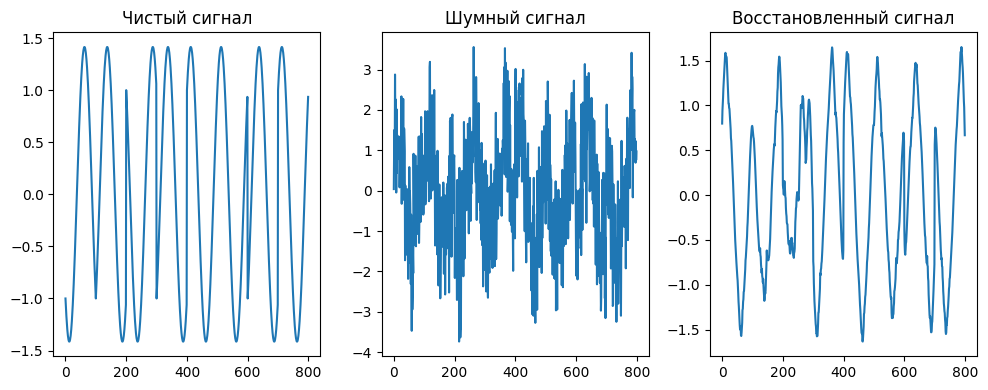

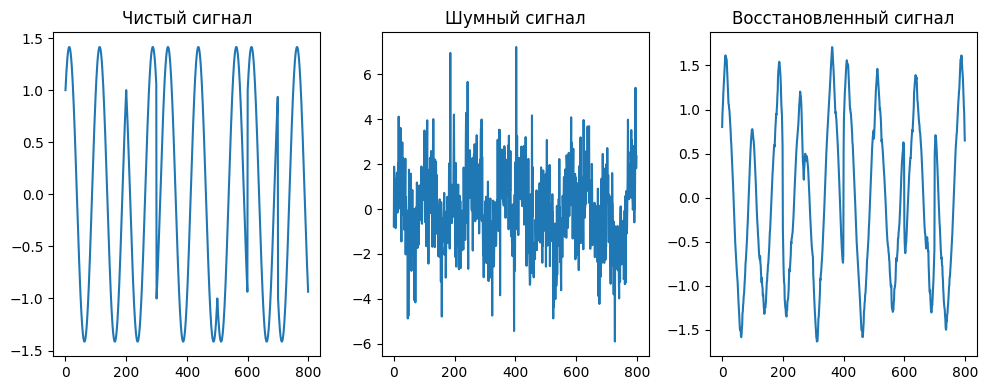

Средняя косинусная близость: [0.9873312497546929, 0.24835760299134196, 0.07193147260631509, -0.1353621695825526, -0.11401338191503307, 0.013856775201177686, -0.13613107767492053, 0.47432794412645674, 0.1955643952454688, 0.0146243159839937]


In [40]:


# Подсчитаем косинусную близость между чистыми и восстановленными сигналами
cosine_similarities = []

with torch.no_grad():
    embeddings = encoder(noised_iq_tensor)
    reconstructed_signals = decoder(embeddings)
    
    for i in range(num_inference_samples):
        # Получаем чистые и восстановленные сигналы
        clean_signal = clean_sign[i, 0, :] - clean_sign[i, 1, :]
        noised_signal = noised_iq[i, 0, :] - noised_iq[i, 1, :]
        reconstructed_signal = reconstructed_signals[i, 0, :].cpu().numpy() - reconstructed_signals[i, 1, :].cpu().numpy()

        # Вычисляем косинусную близость между чистыми и восстановленными сигналами
        cos_sim = cosine_similarity(clean_signal.reshape(1, -1), reconstructed_signal.reshape(1, -1))
        cosine_similarities.append(cos_sim[0][0])
        
        # Визуализация сигналов
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.plot(clean_signal, label="Чистый сигнал")
        plt.title("Чистый сигнал")

        plt.subplot(1, 3, 2)
        plt.plot(noised_signal, label="Шумный сигнал")
        plt.title("Шумный сигнал")

        plt.subplot(1, 3, 3)
        plt.plot(reconstructed_signal, label="Восстановленный сигнал")
        plt.title("Восстановленный сигнал")

        plt.tight_layout()
        plt.show()

# Печать среднее значение косинусной близости
print(f"Средняя косинусная близость: {cosine_similarities}")
